In [1]:
# Import necessary modules

%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

LOG.propagate = False

In [2]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2024-02-14 00:44:31,860 | DEBUG    |: Python Info: sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
2024-02-14 00:44:31,863 | DEBUG    |: System Info: Windows-10-10.0.19045-SP0
2024-02-14 00:44:31,865 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c5:6d:2f:4b
2024-02-14 00:44:54,841 | ERROR    |: 
2024-02-14 00:44:55,846 | WARNING  |: Attempting to connect again...
2024-02-14 00:44:55,850 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c5:6d:2f:4b
2024-02-14 00:45:02,509 | INFO     |: Connected to c0:89:c5:6d:2f:4b


D:\Cornell\Courses\Fast_Robots\Project\ble_python\base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [21]:
acc_roll = []
acc_pitch = []
gyr_roll = []
gyr_pitch = []
gyr_yaw = []
comp_roll = []
comp_pitch = []
timestamp = []   # Stores the corresponding time stamp in seconds

def notification_handler(uuid, byte_array):
    acc_roll.append((float) (ble.bytearray_to_string(byte_array).split(", ")[0]))
    acc_pitch.append((float) (ble.bytearray_to_string(byte_array).split(", ")[1]))
    gyr_roll.append((float) (ble.bytearray_to_string(byte_array).split(", ")[2]))
    gyr_pitch.append((float) (ble.bytearray_to_string(byte_array).split(", ")[3]))
    gyr_yaw.append((float) (ble.bytearray_to_string(byte_array).split(", ")[4]))
    comp_roll.append((float) (ble.bytearray_to_string(byte_array).split(", ")[5]))
    comp_pitch.append((float) (ble.bytearray_to_string(byte_array).split(", ")[6]))
    timestamp.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[-1]))/1000)

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

#### Accelerometer

In [177]:
acc_roll.clear()
acc_pitch.clear()
ble.send_command(CMD.GET_ANGLES, "100")

In [30]:
# Average the measured angles
acc_roll_avg = sum(acc_roll)/len(acc_roll)
acc_pitch_avg = sum(acc_pitch)/len(acc_pitch)

print("Averaged roll: ", acc_roll_avg, ", averaged pitch: ", acc_pitch_avg, sep="")

Averaged roll: -31.63696, averaged pitch: -86.42894


##### Fourier Transform

###### Roll

In [78]:
acc_roll.clear()
acc_pitch.clear()
acc_timestamp.clear()
ble.send_command(CMD.GET_ANGLES, "500")

In [179]:
N = len(acc_roll)
sample_rate = int(N/(timestamp[-1] - timestamp[0]))

# Time domain
x_time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=N)

# Frequency domain
x_freq = np.linspace(0., sample_rate/2, num=int(N/2))
fft_acc_roll = fft(acc_roll)
y_freq_acc_roll = 2/N * np.abs(fft_acc_roll[0:int(N/2)])  # Positive part of the magnitude spectrum


# Low-pass complimentary filter
alpha = 0.16
y_time_filt_acc_roll = np.zeros(len(acc_roll))
y_time_filt_acc_roll[0] = acc_roll[0]
for i in range(1, len(acc_roll)):
    y_time_filt_acc_roll[i] = alpha*acc_roll[i]+(1-alpha)*y_time_filt_acc_roll[i-1]
    
fft_filtered_acc_roll = fft(y_time_filt_acc_roll)
y_freq_filt_acc_roll = 2/N * np.abs(fft_filtered_acc_roll[0:int(N/2)])  # Positive part of the magnitude spectrum


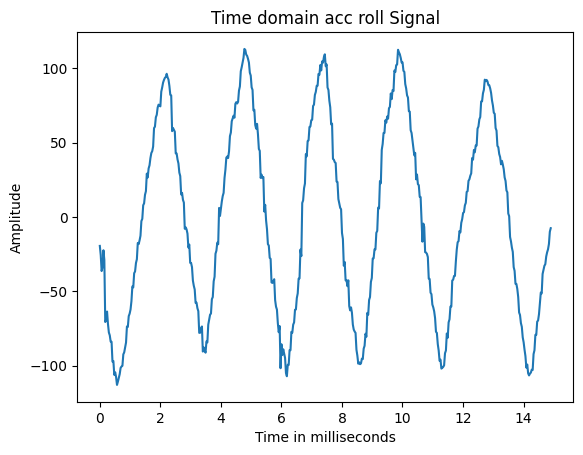

In [86]:
# Time domain
plt.plot(x_time, acc_roll)
plt.title('Time domain acc roll Signal')
plt.xlabel('Time in milliseconds')
plt.ylabel('Amplitude')
plt.show()

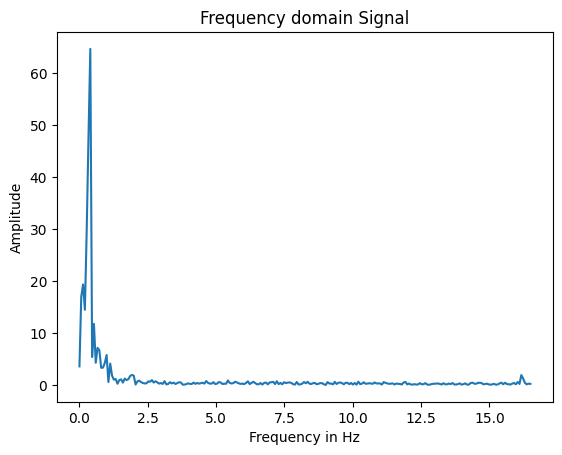

In [87]:
# Magnitude Spectrum
plt.plot(x_freq, y_freq_acc_roll)
plt.title('Frequency domain Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.show()

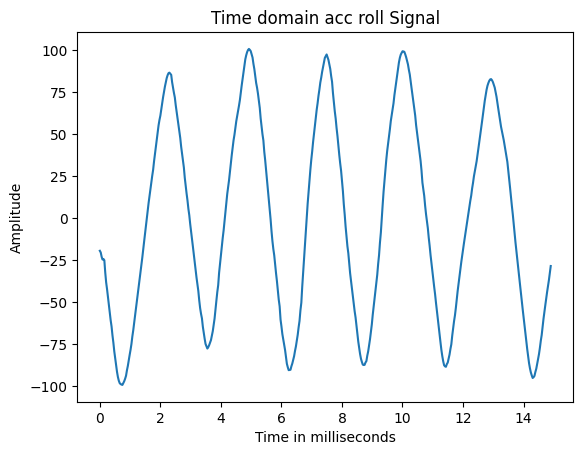

In [88]:
# Time domain after low-pass filtering
plt.plot(x_time, y_time_filt_acc_roll)
plt.title('Time domain acc roll Signal')
plt.xlabel('Time in milliseconds')
plt.ylabel('Amplitude')
plt.show()

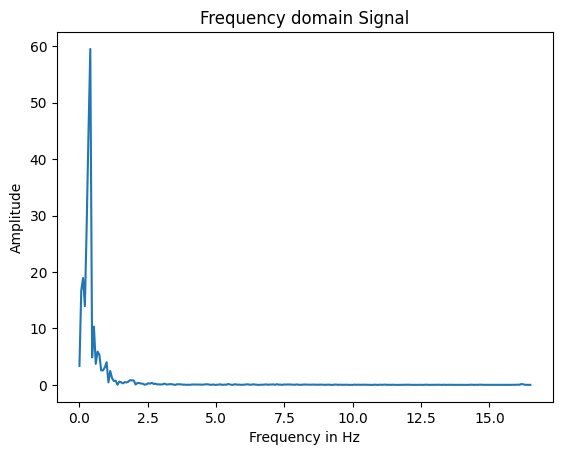

2024-02-11 16:00:16,228 | INFO     |: Disconnected from C0:89:C5:6D:2F:4B


In [89]:
# Magnitude Spectrum
plt.plot(x_freq, y_freq_filt_acc_roll)
plt.title('Frequency domain Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.show()

#### Gyroscope

In [163]:
acc_roll.clear()
acc_pitch.clear()
gyr_roll.clear()
gyr_pitch.clear()
gyr_yaw.clear()
timestamp.clear()
ble.send_command(CMD.GET_ANGLES, "200")

In [141]:
N = len(acc_roll)
sample_rate = int(N/(timestamp[-1] - timestamp[0]))

########## Roll
# Time domain
x_time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=N)

# Low-pass complimentary filter for acc
alpha = 0.16
y_time_filt_acc_roll = np.zeros(len(acc_roll))
y_time_filt_acc_roll[0] = acc_roll[0]
for i in range(1, len(acc_roll)):
    y_time_filt_acc_roll[i] = alpha*acc_roll[i]+(1-alpha)*y_time_filt_acc_roll[i-1]

# Frequency domain
x_freq = np.linspace(0., sample_rate/2, num=int(N/2))
fft_acc_roll = fft(acc_roll)
y_freq_acc_roll = 2/N * np.abs(fft_acc_roll[0:int(N/2)])  # Positive part of the magnitude spectrum

fft_gyr_roll = fft(gyr_roll)
y_freq_gyr_roll = 2/N * np.abs(fft_gyr_roll[0:int(N/2)])  # Positive part of the magnitude spectrum


########## Pitch
# Low-pass complimentary filter for acc
alpha = 0.16
y_time_filt_acc_pitch = np.zeros(len(acc_pitch))
y_time_filt_acc_pitch[0] = acc_pitch[0]
for i in range(1, len(acc_pitch)):
    y_time_filt_acc_pitch[i] = alpha*acc_roll[i]+(1-alpha)*y_time_filt_acc_roll[i-1]

# Frequency domain
fft_acc_pitch = fft(acc_pitch)
y_freq_acc_pitch = 2/N * np.abs(fft_acc_pitch[0:int(N/2)])  # Positive part of the magnitude spectrum

fft_gyr_pitch = fft(gyr_pitch)
y_freq_gyr_pitch = 2/N * np.abs(fft_gyr_pitch[0:int(N/2)])  # Positive part of the magnitude spectrum


########## Yaw
# Frequency domain
fft_gyr_yaw = fft(gyr_yaw)
y_freq_gyr_yaw = 2/N * np.abs(fft_gyr_yaw[0:int(N/2)])  # Positive part of the magnitude spectrum

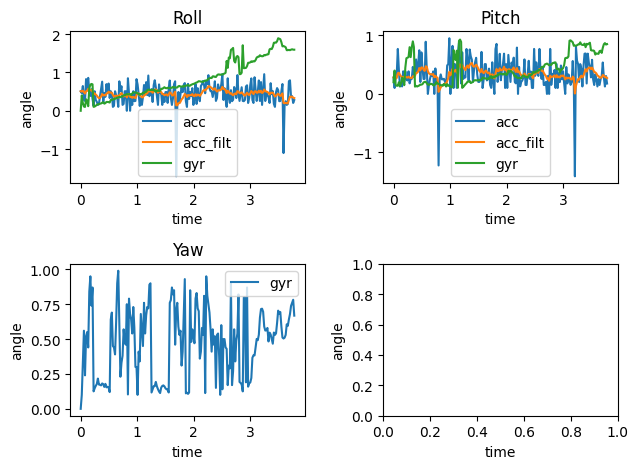

In [142]:
# Time domain figure
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x_time, acc_roll, label='acc')
axs[0, 0].plot(x_time, y_time_filt_acc_roll, label='acc_filt')
axs[0, 0].plot(x_time, gyr_roll, label='gyr', )
axs[0, 0].legend()
axs[0, 0].set_title('Roll')
axs[0, 1].plot(x_time, acc_pitch, label='acc')
axs[0, 1].plot(x_time, y_time_filt_acc_pitch, label='acc_filt')
axs[0, 1].plot(x_time, gyr_pitch, label='gyr')
axs[0, 1].legend()
axs[0, 1].set_title('Pitch')
axs[1, 0].plot(x_time, gyr_yaw, label='gyr')
axs[1, 0].legend()
axs[1, 0].set_title('Yaw')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='angle')

fig.tight_layout()
plt.show()

In [144]:
print(sample_rate)

52


##### Complementary filter

In [24]:
acc_roll.clear()
acc_pitch.clear()
gyr_roll.clear()
gyr_pitch.clear()
gyr_yaw.clear()
comp_roll.clear()
comp_pitch.clear()
timestamp.clear()
ble.send_command(CMD.GET_ANGLES, "2000")

In [168]:
N = len(acc_roll)
sample_rate = int(N/(timestamp[-1] - timestamp[0]))

########## Roll
# Time domain
x_time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=N)

# Low-pass complimentary filter for acc
alpha = 0.16
y_time_filt_acc_roll = np.zeros(len(acc_roll))
y_time_filt_acc_roll[0] = acc_roll[0]
for i in range(1, len(acc_roll)):
    y_time_filt_acc_roll[i] = alpha*acc_roll[i]+(1-alpha)*y_time_filt_acc_roll[i-1]


########## Pitch
# Low-pass complimentary filter for acc
alpha = 0.16
y_time_filt_acc_pitch = np.zeros(len(acc_pitch))
y_time_filt_acc_pitch[0] = acc_pitch[0]
for i in range(1, len(acc_pitch)):
    y_time_filt_acc_pitch[i] = alpha*acc_pitch[i]+(1-alpha)*y_time_filt_acc_pitch[i-1]


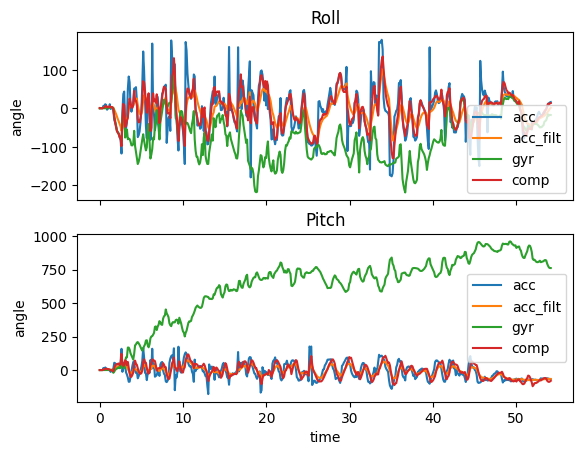

2024-02-13 02:08:12,115 | INFO     |: Disconnected from C0:89:C5:6D:2F:4B


In [169]:
# Time domain figure
fig, axs = plt.subplots(2, 1)
axs[0].plot(x_time, acc_roll, label='acc')
axs[0].plot(x_time, y_time_filt_acc_roll, label='acc_filt')
axs[0].plot(x_time, gyr_roll, label='gyr')
axs[0].plot(x_time, comp_roll, label='comp')
axs[0].legend()
axs[0].set_title('Roll')
axs[1].plot(x_time, acc_pitch, label='acc')
axs[1].plot(x_time, y_time_filt_acc_pitch, label='acc_filt')
axs[1].plot(x_time, gyr_pitch, label='gyr')
axs[1].plot(x_time, comp_pitch, label='comp')
axs[1].legend()
axs[1].set_title('Pitch')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='angle')

for ax in fig.get_axes():
    ax.label_outer()
plt.show()

#### Sample Data

In [7]:
comp_roll.clear()
comp_pitch.clear()
comp_yaw.clear()
timestamp.clear()
ble.send_command(CMD.START_RECORD, "")

In [8]:
ble.send_command(CMD.GET_RECORDED_DATA, "")

In [3]:
comp_roll = []
comp_pitch = []
comp_yaw = []
timestamp = []   # Stores the corresponding time stamp in seconds

def notification_handler(uuid, byte_array):
    comp_roll.append((float) (ble.bytearray_to_string(byte_array).split(", ")[0]))
    comp_pitch.append((float) (ble.bytearray_to_string(byte_array).split(", ")[1]))
    comp_yaw.append((float) (ble.bytearray_to_string(byte_array).split(", ")[2]))
    timestamp.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[-1]))/1000)

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [6]:
comp_roll.clear()
comp_pitch.clear()
comp_yaw.clear()
timestamp.clear()
ble.send_command(CMD.START_RECORD, "")
time.sleep(5)
ble.send_command(CMD.GET_RECORDED_DATA, "")

Sampled 1348 sets of data in 5.13 seconds, at a frequency of 262


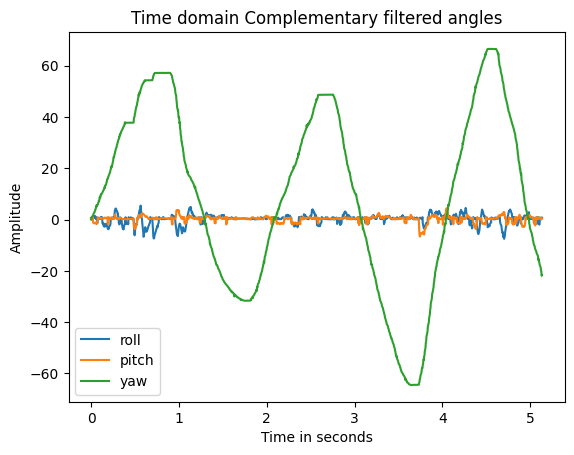

In [7]:
N = len(comp_roll)
sample_rate = int(len(comp_roll)/(timestamp[-1] - timestamp[0]))
print("Sampled", N, "sets of data in", "%.2f" %(timestamp[-1] - timestamp[0]), "seconds, at a frequency of", sample_rate)

# Time domain figure
x_time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=N)
plt.plot(x_time, comp_roll, label='roll')
plt.plot(x_time, comp_pitch, label='pitch')
plt.plot(x_time, comp_yaw, label='yaw')
plt.legend()
plt.title('Time domain Complementary filtered angles')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
plt.show()